## Advanced Alphalens Concepts

You've learned the basics of using Alphalens. This lesson explores the following advanced Alphalens concepts: 
1. Determining how far an alpha factor's predictive value stretches into the future.
2. Dealing with a common Alphalens error named MaxLossExceededError.
3. Grouping assets by sector, then analyzing each sector individually.
4. Writing group neutral strategies.

The following code creates an alpha factor in a pipeline. The rest of this lesson will discuss advanced Alphalens concepts using the data created by the pipeline.

Important note: Until this lesson, we passed the output of `run_pipeline()` to `get_clean_factor_and_forward_returns()` without any changes. This was possible because the previous lessons' pipelines only returned one column. This lesson's pipeline returns two columns, which means we need to specify the column we're passing as factor data. Look for commented code near `get_clean_factor_and_forward_returns()` in the following cell to see how to do this. 

In [1]:
from zipline.pipeline.fundamentals import Fundamentals

from zipline.pipeline import Pipeline
from zipline.research import run_pipeline
from zipline.pipeline.factors import CustomFactor, SimpleMovingAverage
# 自builtin导入
from zipline.pipeline.builtin import QTradableStocksUS, Sector
from zipline.pipeline.data import EquityPricing
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns


def make_pipeline():
    # 以下使用的季度数据
    # 使用净资产增长率
    change_in_working_capital = Fundamentals.q_financial_indicators.净资产增长率.latest
    ciwc_processed = change_in_working_capital.winsorize(.2, .98).zscore()
    
    # 营业利润 / 净资产
    sales_per_working_capital = Fundamentals.q_profit_statement.营业利润.latest / Fundamentals.balance_sheet.所有者权益或股东权益合计.latest
    spwc_processed = sales_per_working_capital.winsorize(.2, .98).zscore()

    factor_to_analyze = (ciwc_processed + spwc_processed).zscore()

    sector = Sector()

    return Pipeline(
        columns = {
            'factor_to_analyze': factor_to_analyze,
            'sector': sector,
        },
        screen = (
            QTradableStocksUS()
            & factor_to_analyze.notnull()
            & sector.notnull()
        )
    )

In [2]:
from zipline.research import get_pricing

In [3]:
pipeline_output = run_pipeline(make_pipeline(), '2018-1-1', '2019-1-1')
pricing_data = get_pricing(pipeline_output.index.levels[1], '2018-1-1', '2019-3-1', fields='open')


factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'], # How to analyze a specific pipeline column with Alphalens
    pricing_data, 
    periods=range(1,32,3)
)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Visualizing an alpha factor's decay rate
A lot of fundamental data only comes out 4 times a year in quarterly reports. Because of this low frequency, it can be useful to increase the amount of time `get_clean_factor_and_forward_returns()` looks into the future to calculate returns.

Tip: A month usually has 21 trading days, a quarter usually has 63 trading days, and a year usually has 252 trading days.

Let's say you're creating a strategy that buys stock in companies with rising profits (data that is released every 63 trading days). Would you only look 10 days into the future to analyze that factor? Probably not! But how do you decide how far to look forward?

The following code charts our alpha factor's IC mean over time. 

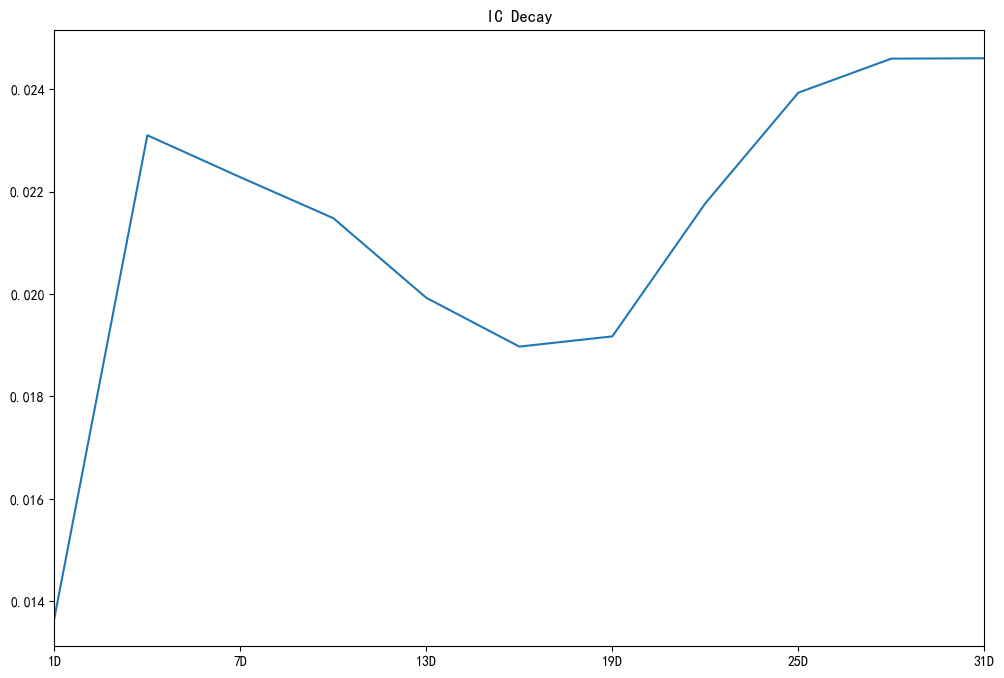

In [4]:
from alphalens.performance import mean_information_coefficient
mean_information_coefficient(factor_data).plot(title="IC Decay");

The point where the line dips below 0 represents when our alpha factor's predictions stop being useful. 

What do you think the chart will look like if we calculate the IC a full year into the future?

*Hint*: This is a setup for section two of this lesson. 

In [5]:
factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'], 
    pricing_data,
    periods=range(1,252,20) # The third argument to the range statement changes the "step" of the range
)

mean_information_coefficient(factor_data).plot()

Dropped 84.6% entries from factor data: 84.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).


MaxLossExceededError: max_loss (35.0%) exceeded 84.6%, consider increasing it.

## Dealing With MaxLossExceededError
Oh No! What does `MaxLossExceededError: max_loss (35.0%) exceeded 88.4%, consider increasing it.` mean?

`get_clean_factor_and_forward_returns()` aligns data from an alpha factor with forward looking returns data. This means we need our pricing data to go further into the future than our alpha factor data by at least as long as our forward looking period. In this case, we'll change `get_pricing()`'s `end_date` argument to be at least a year after `run_pipeline()`'s `end_date` argument.

The following code shows how to make those changes. 

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


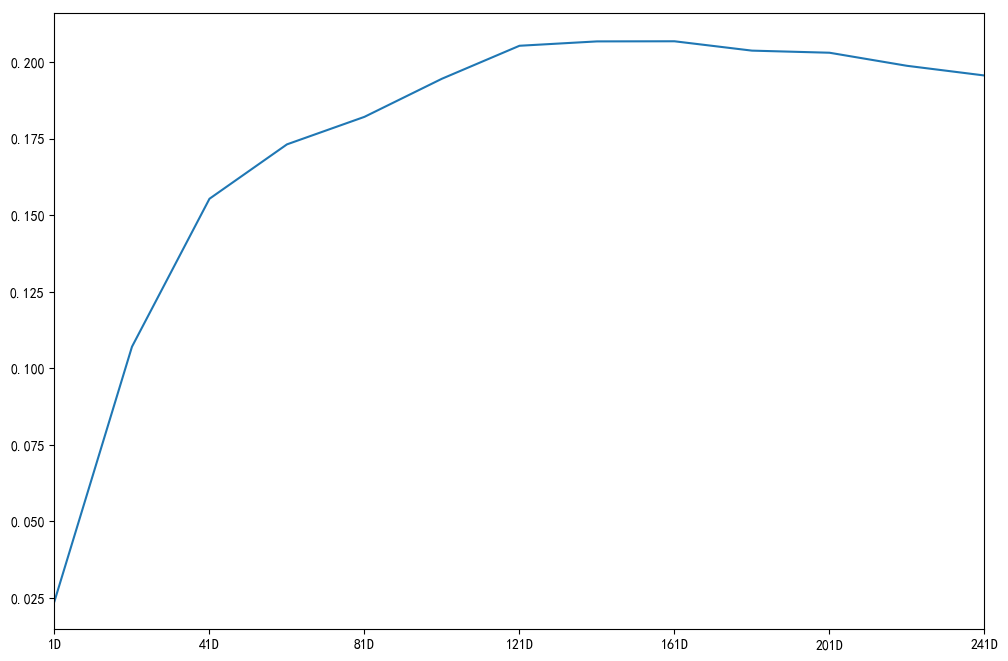

In [7]:
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date='2017-1-1', 
    end_date='2018-1-1' #  *** NOTE *** Our factor data ends in 2014
)

pricing_data = get_pricing(
    pipeline_output.index.levels[1], 
    start_date='2017-1-1',
    end_date='2019-2-1', # *** NOTE *** Our pricing data ends in 2015
    fields='open'
)

factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'], 
    pricing_data,
    periods=range(1,252,20) # Change the step to 10 or more for long look forward periods to save time
)

mean_information_coefficient(factor_data).plot()

As you can see, this alpha factor's IC decays quickly after a few days, but comes back even stronger than before six months into the future. Interesting! 

Note: `MaxLossExceededError` has two possible causes; forward returns computation and binning. We showed you how to fix forward returns computation here because it is much more common. You can read more about what binning is in the API docs. 

## Analyzing Alpha Factors By Group
Alphalens allows you to group assets using a classifier. A common use case for this is creating a classifier that specifies which sector each equity belongs to, then comparing your alpha factor's returns among sectors.

You can group assets by any classifier, but sector is most common. The pipeline in the first cell of this lesson returns a column named sector, whose values represent the corresponding Morningstar sector code. All we have to do now is pass that column to the groupby argument of `get_clean_factor_and_forward_returns()`

The following code shows how to make those changes. 

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
收益率分析


,1D,5D,10D
Ann. alpha,0.153,0.141,0.134
beta,-0.100,-0.116,-0.109
最高分位数周期平均收益率(基点),8.093,7.595,7.254
最低分位数周期平均收益率(基点),-6.163,-6.071,-5.902
周期平均展布(基点),14.255,13.663,13.157


<Figure size 1200x800 with 0 Axes>

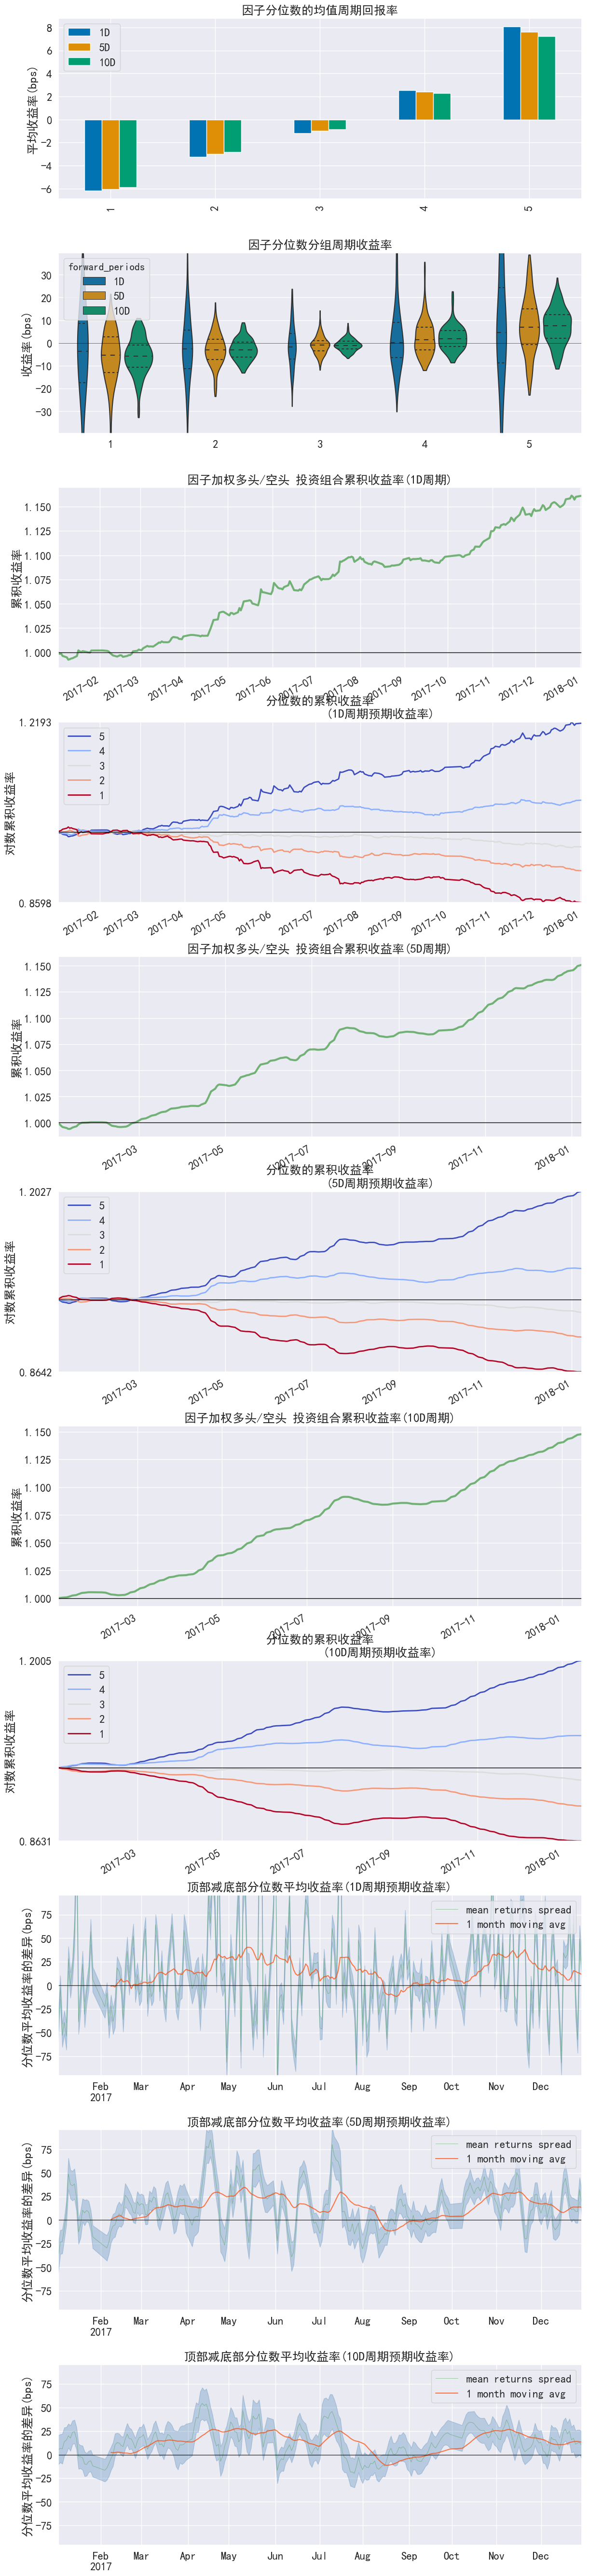

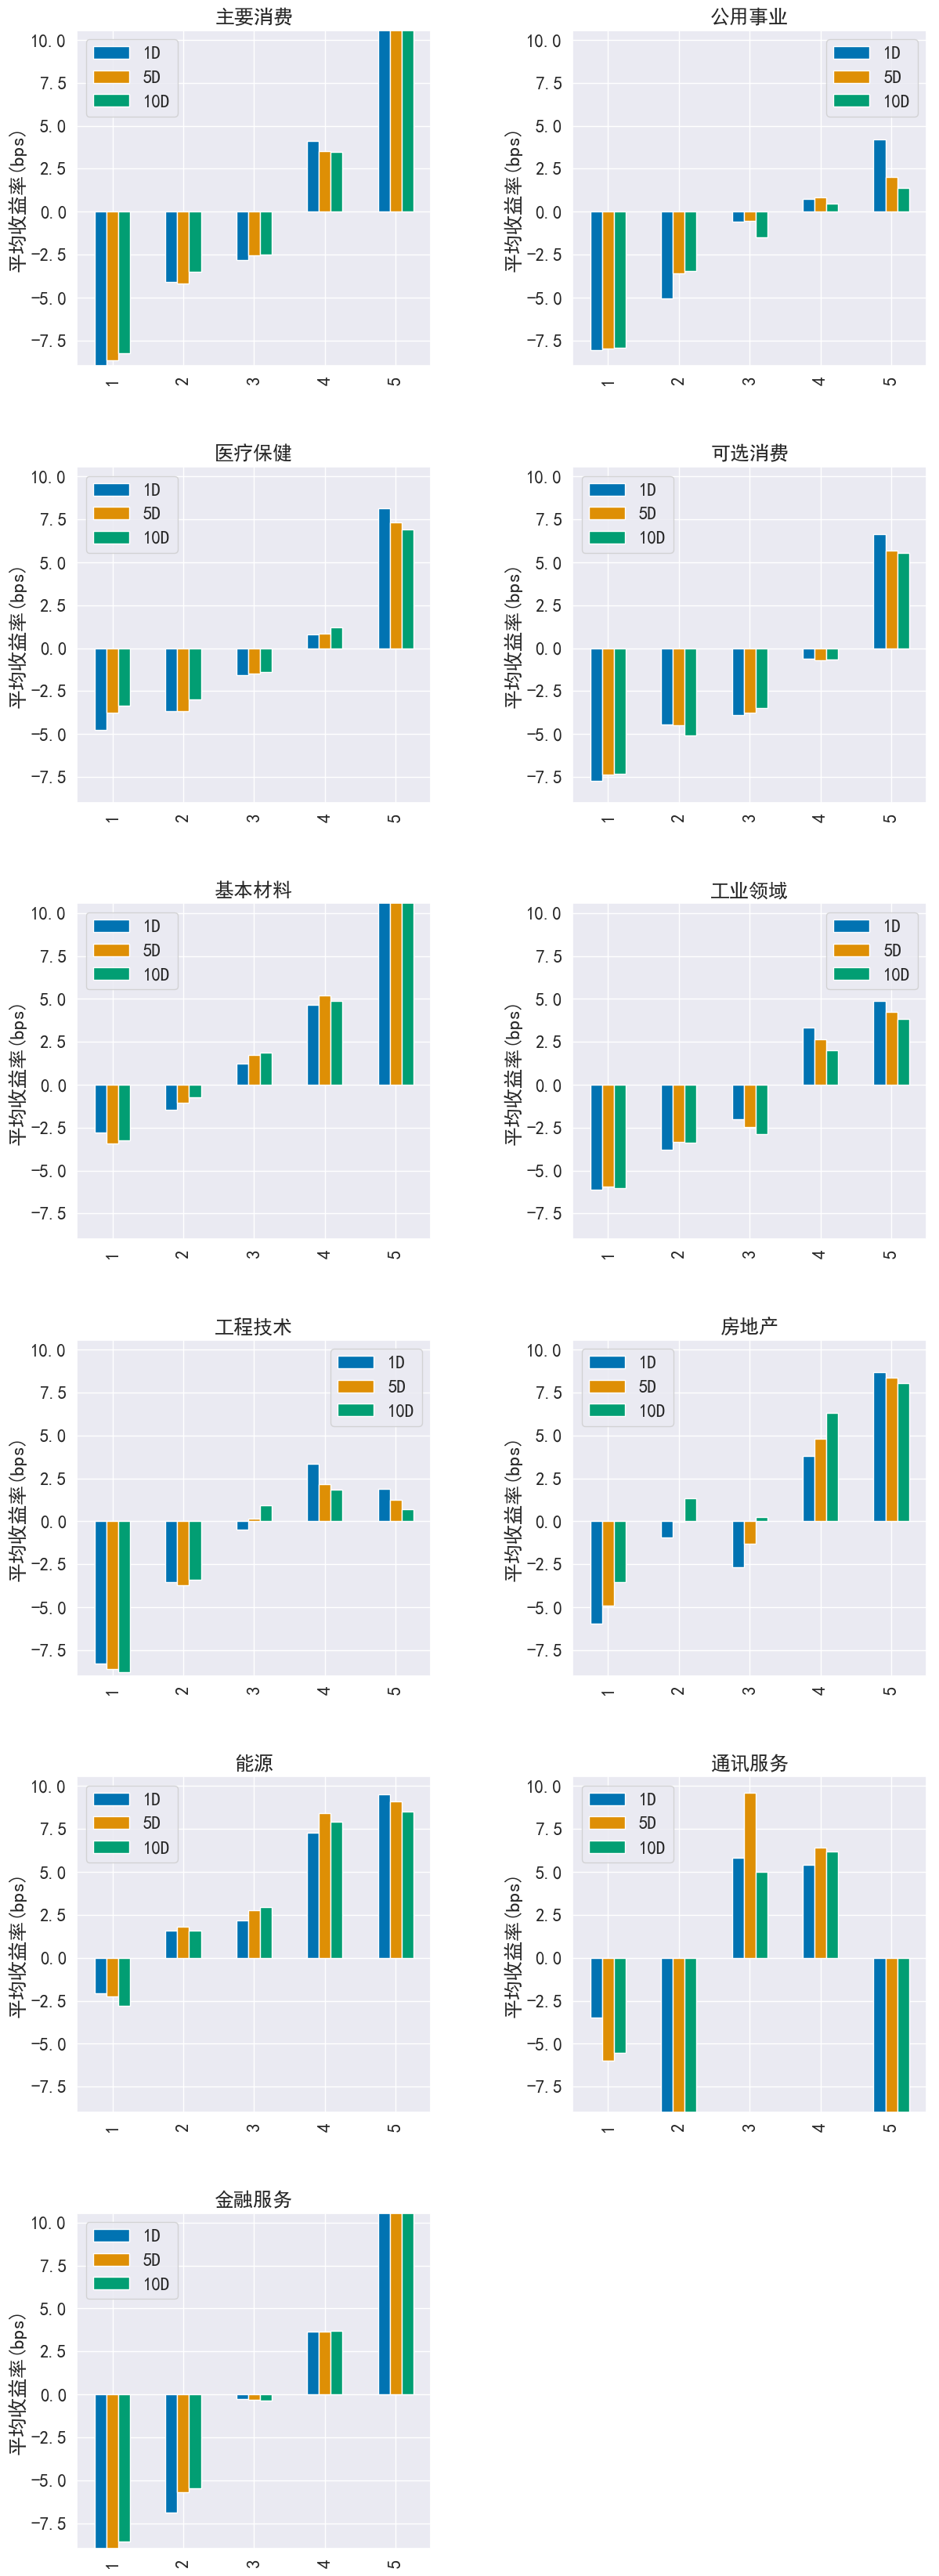

In [8]:
from alphalens.tears import create_returns_tear_sheet

sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

factor_data = get_clean_factor_and_forward_returns(
    factor=pipeline_output['factor_to_analyze'],
    prices=pricing_data,
    groupby=pipeline_output['sector'],
    groupby_labels=sector_labels,
)

create_returns_tear_sheet(factor_data=factor_data, by_group=True)

## Writing Group Neutral Strategies
Not only does Alphalens allow us to simulate how our alpha factor would perform in a long/short trading strategy, it also allows us to simulate how it would do if we went long/short on every group!

Grouping by sector, and going long/short on each sector allows you to limit exposure to the overall movement of sectors. For example, you may have noticed in step three of this tutorial, that certain sectors had all positive returns, or all negative returns. That information isn't useful to us, because that just means the sector group outperformed (or underperformed) the market; it doesn't give us any insight into how our factor performs within that sector.

Since we grouped our assets by sector in the previous cell, going group neutral is easy; just make the two following changes:

1. Pass `binning_by_group=True` as an argument to `get_clean_factor_and_forward_returns()`.
2. Pass `group_neutral=True` as an argument to `create_full_tear_sheet()`.

The following cell has made the approriate changes. Try running it and notice how the results differ from the previous cell.

Dropped 2.1% entries from factor data: 0.0% in forward returns computation and 2.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
收益率分析


,1D,5D,10D
Ann. alpha,0.133,0.125,0.120
beta,-0.094,-0.097,-0.086
最高分位数周期平均收益率(基点),8.051,7.470,7.126
最低分位数周期平均收益率(基点),-6.045,-6.016,-5.912
周期平均展布(基点),14.096,13.483,13.038


<Figure size 1200x800 with 0 Axes>

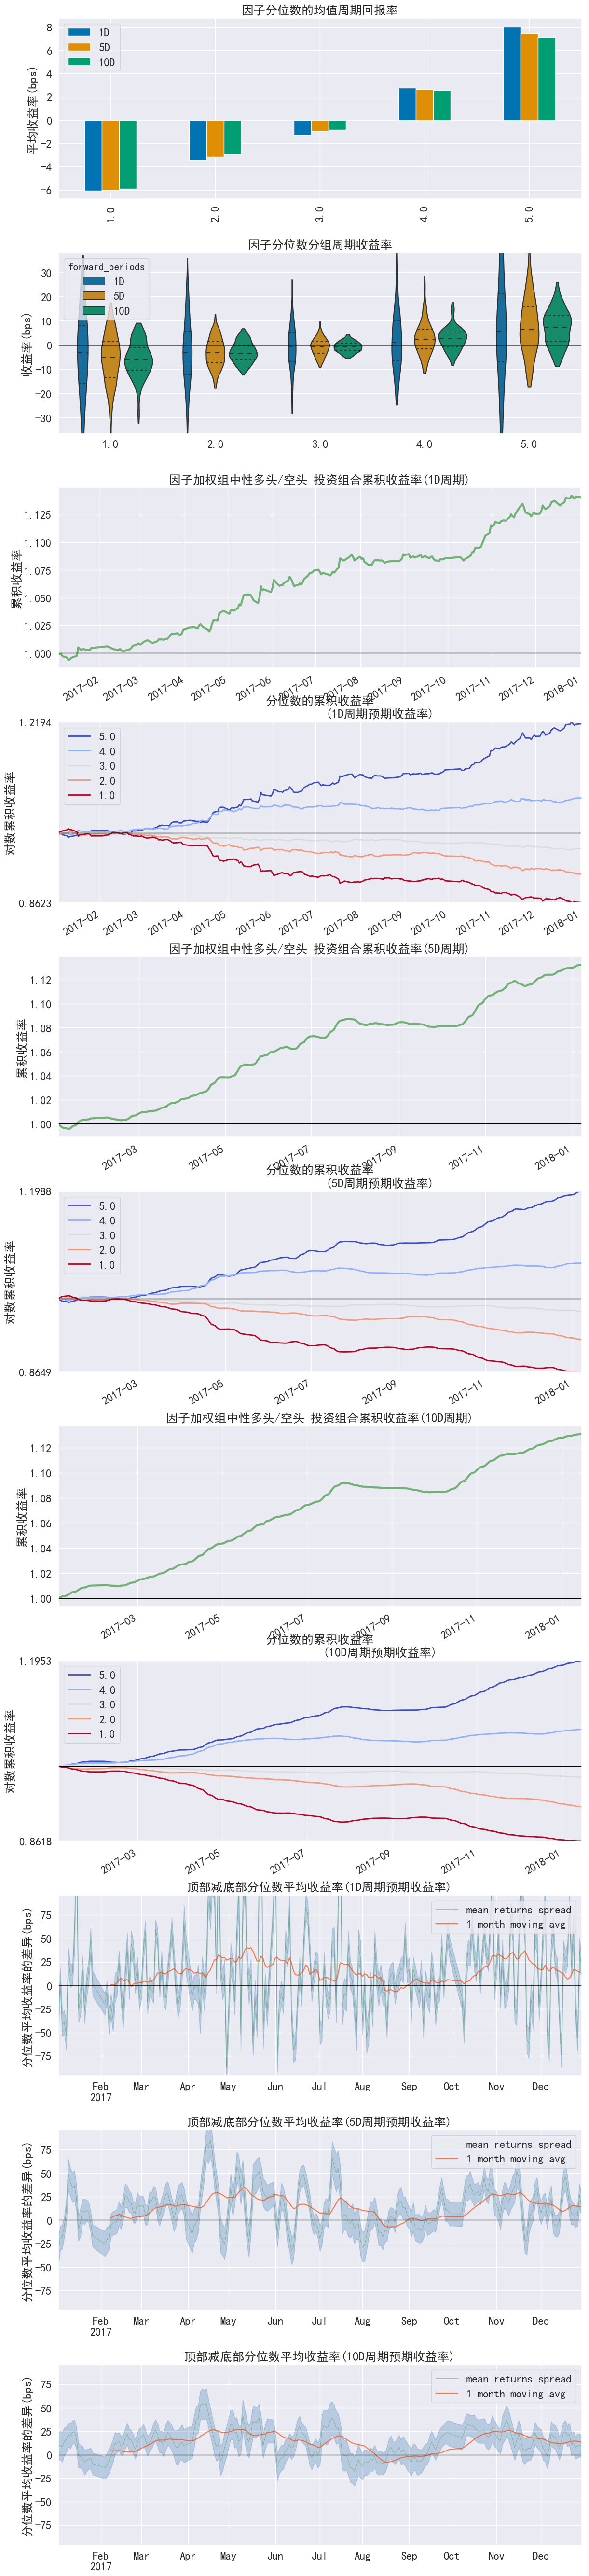

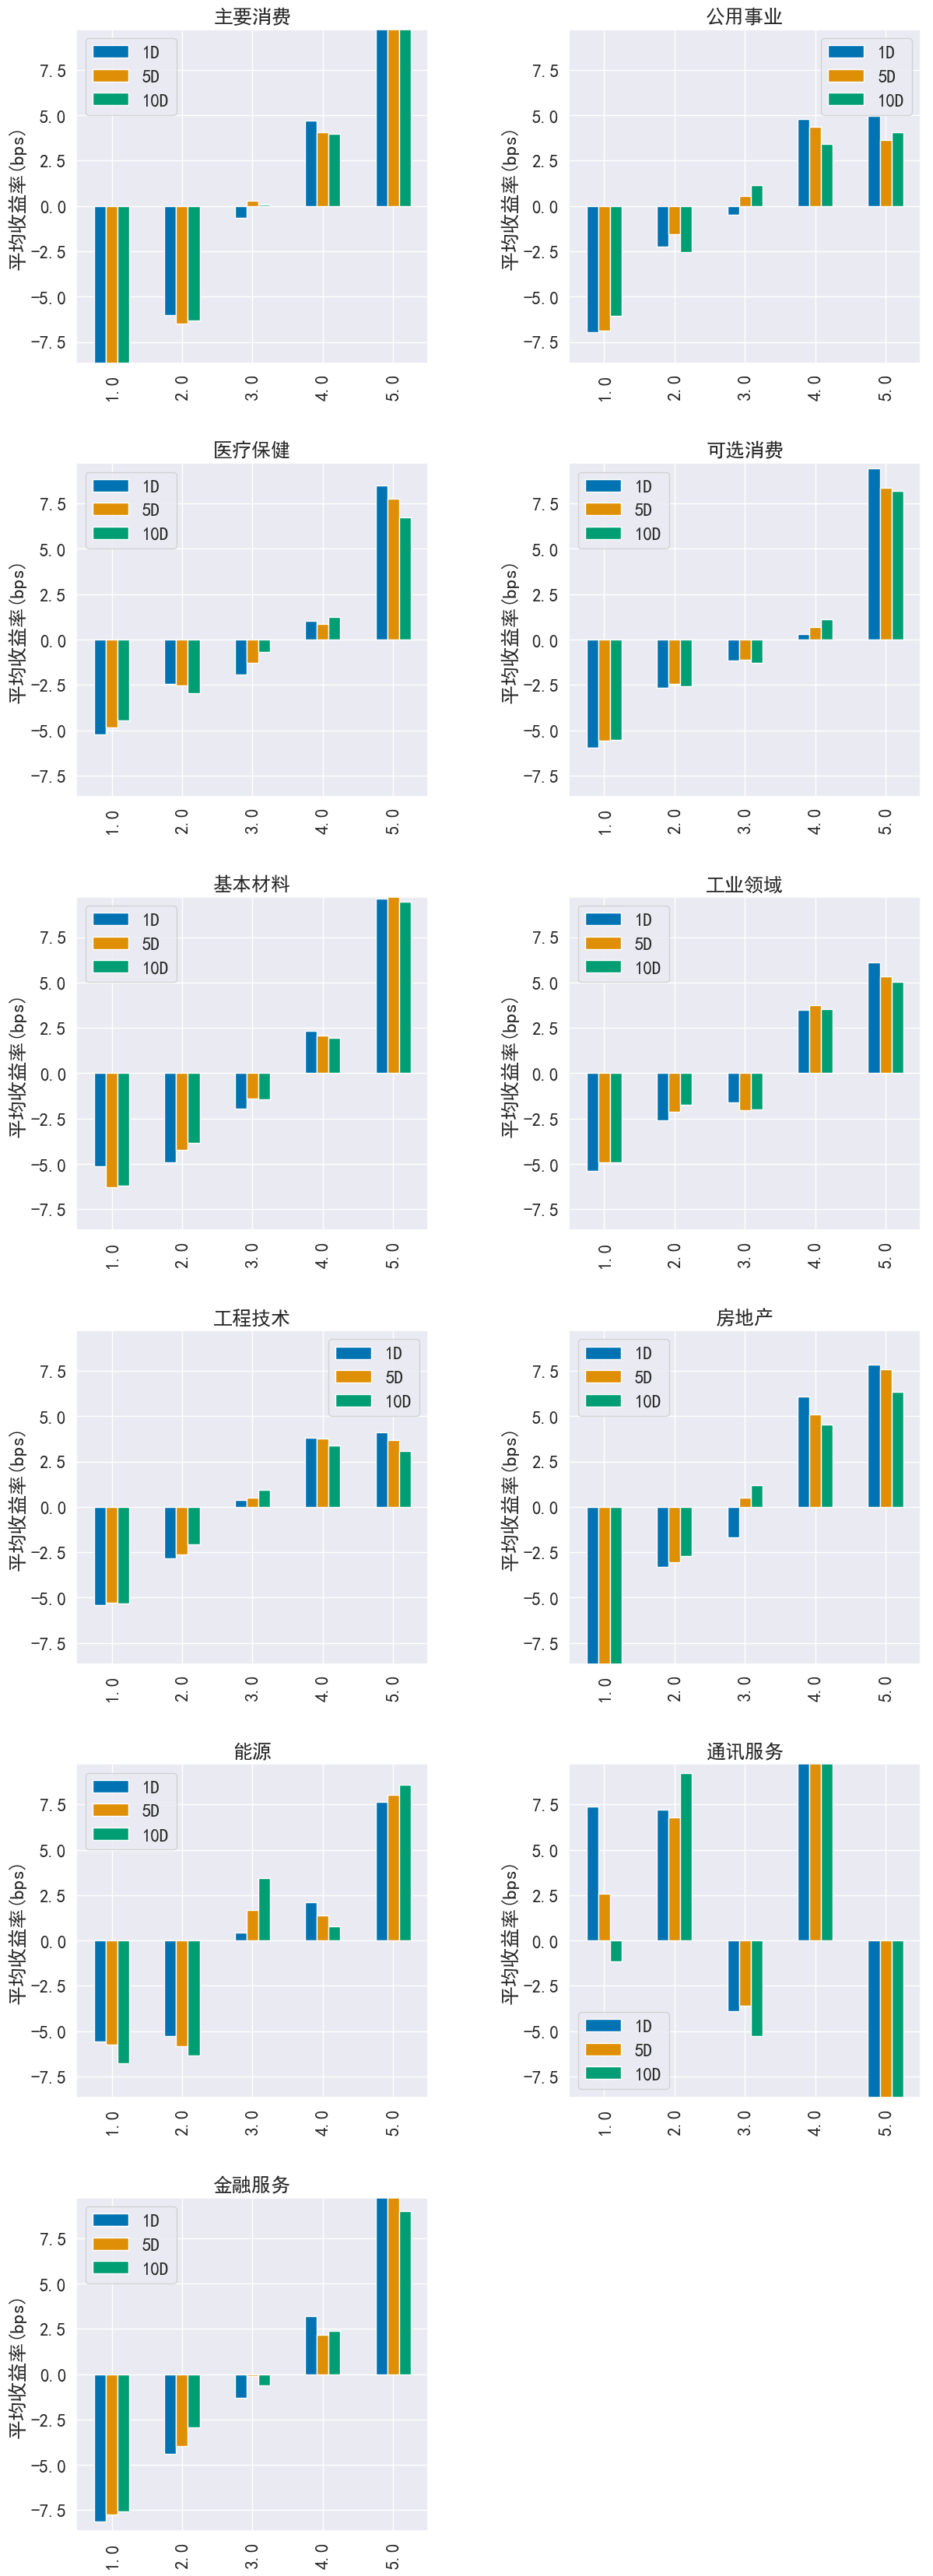

In [11]:
factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'],
    prices=pricing_data,
    groupby=pipeline_output['sector'],
    groupby_labels=sector_labels,
    binning_by_group=True,
)

create_returns_tear_sheet(factor_data, by_group=True, group_neutral=True);

As you can see, the results are different when we go group neutral. You can sometimes get insights into why your alpha factor is behaving in a certain way by analyzing it in a group neutral fashion. 

That's it!

The techniques you learned in this tutorial will help you identify good alpha factors. Use the template on the following page to create a few alpha factors, then try implementing them in the IDE to enter into the Quantopian Contest! 